In [1]:
# IMPORTS

import numpy as np
from pathlib import Path
import glob2
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.visualization.visualization_fct import mask_to_rgb

# CONSTANTS

path = '../data/raw/carseg_data/clean_data/'

In [2]:
# NB OF FILES IN CLEAN DATASET: 3521

all_paths = [ Path(p).absolute() for p in glob2.glob(path + '*') ]
print('Number of files:', len(all_paths))
assert len(all_paths) == 3521

Number of files: 3521


In [3]:
# load all files
all_files = [np.load(f) for f in all_paths]

In [4]:
# total number of classes? 9

all_len_classes = [len(list(set(a[3].flatten()))) for a in all_files]

print('Max nb of distinct classes:', max(all_len_classes))

Max nb of distinct classes: 9


In [4]:
all_stems = np.array([f.stem for f in all_paths])

# load test set
test_ids = np.loadtxt('../references/test_set_ids.txt', dtype=str)
test_stems = np.array([f.split('.')[0] for f in test_ids])
test_paths = np.array(all_paths)[np.isin(all_stems, test_stems)]
test_files = np.array(all_files)[np.isin(all_stems, test_stems)]
print('Test set:', test_ids)

Test set: ['0_a.jpg' '1_a.jpg' '2_a.jpg' '3_a.jpg' '5_a.jpg' '6_a.jpg' '10_a.jpg'
 '11_a.jpg' '12_a.jpg' '19_a.jpg' '20_a.jpg' '21_a.jpg' '22_a.jpg'
 '24_a.jpg' '26_a.jpg' '28_a.jpg' '29_a.jpg' '32_a.jpg' '33_a.jpg'
 '35_a.jpg' '36_a.jpg' '39_a.jpg' '40_a.jpg' '43_a.jpg' '45_a.jpg'
 '46_a.jpg' '47_a.jpg' '50_a.jpg' '51_a.jpg' '52_a.jpg']


In [5]:
# train set
train_stems = [s for s in all_stems if not s in test_stems]
train_paths = np.array(all_paths)[np.array([not s in test_stems for s in all_stems])]
train_files = np.array(all_files)[np.array([not s in test_stems for s in all_stems])]

[0.0, 1.0, 4.0, 7.0, 8.0]
Shape img: (256, 256, 3)


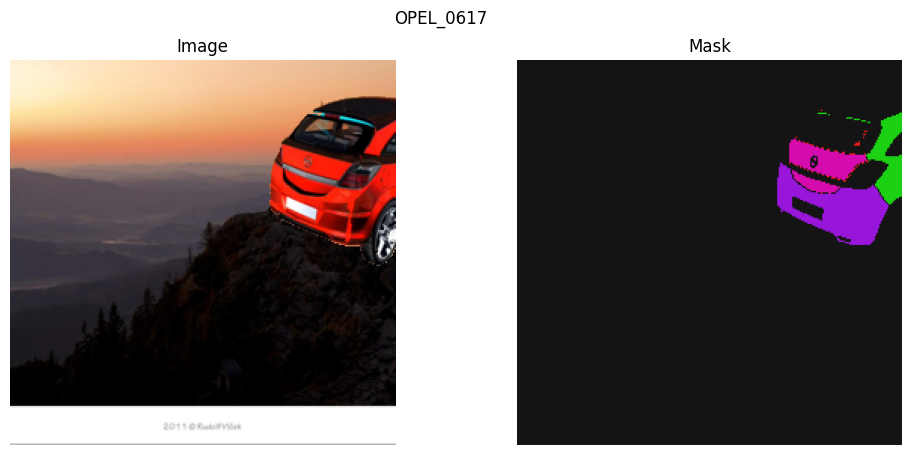

In [6]:
# see a random picture

files_to_consider, paths_to_consider = train_files, train_paths

index = np.random.randint(len(files_to_consider))
img_ex = train_files[index]

labels_in_img = list(set(img_ex[3].flatten()))
print(labels_in_img)

anImage = (np.transpose(img_ex[:3], (1, 2, 0))*255).astype(int)
print('Shape img:', anImage.shape)

plt.figure(figsize=(12,5), facecolor='white')
plt.suptitle(paths_to_consider[index].stem)

plt.subplot(1,2,1)
plt.title('Image')
plt.imshow(anImage) 
plt.axis(False)

plt.subplot(1,2,2)
plt.title('Mask')
plt.imshow(mask_to_rgb(img_ex[3]), cmap='jet')
plt.axis(False)

plt.show()

In [7]:
# distribution of car parts

# we want to know the frequency of each class + the average % of area of each class per image

nb_max_classes = 9

class_freq = dict(zip(list(range(nb_max_classes)), [0]*nb_max_classes))
class_avg_area = {}

for i in tqdm(range(len(files_to_consider))):
    img_ex = files_to_consider[i]
    img_path = paths_to_consider[i]
    distinct_classes_found = np.array(list(set(img_ex[3].flatten())), dtype=int)
    for aClass in distinct_classes_found:
        class_freq[aClass] += 1
        if not (aClass in list(class_avg_area.keys())):
            class_avg_area[aClass] = [np.mean(img_ex[3].flatten() == float(aClass))]
        else:
            class_avg_area[aClass].append(np.mean(img_ex[3].flatten() == float(aClass)))

100%|██████████| 3491/3491 [00:23<00:00, 147.97it/s]


In [8]:
# get %
class_freq = {k:v/len(files_to_consider) for k,v in class_freq.items()}
# sort
class_freq = dict(sorted(class_freq.items(), key=lambda x:x[1]))

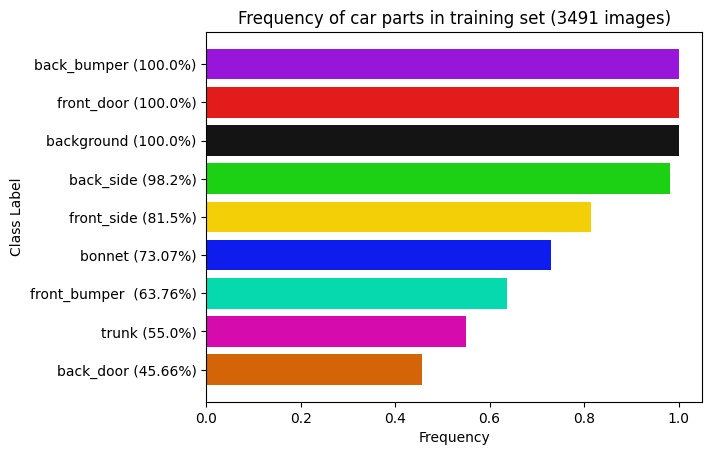

In [9]:
from src.visualization.visualization_fct import get_mask_colors, get_mask_names

all_colors, all_names = get_mask_colors(), get_mask_names()

# plot class freq
plt.barh(list(range(nb_max_classes)), list(class_freq.values()), color= [all_colors[aClass] for aClass in list(class_freq.keys())])
plt.yticks(list(range(nb_max_classes)), [f'{all_names[c]} ({round(class_freq[c]*100, 2)}%)' for c in list(class_freq.keys())])
plt.ylabel('Class Label')
plt.xlabel('Frequency')
plt.title(f'Frequency of car parts in training set ({len(files_to_consider)} images)')
plt.show()

In [10]:
# apply mean
class_avg_area = {k:np.mean(v) for k,v in class_avg_area.items()}
# sort
class_avg_area = dict(sorted(class_avg_area.items(), key=lambda x:x[1]))

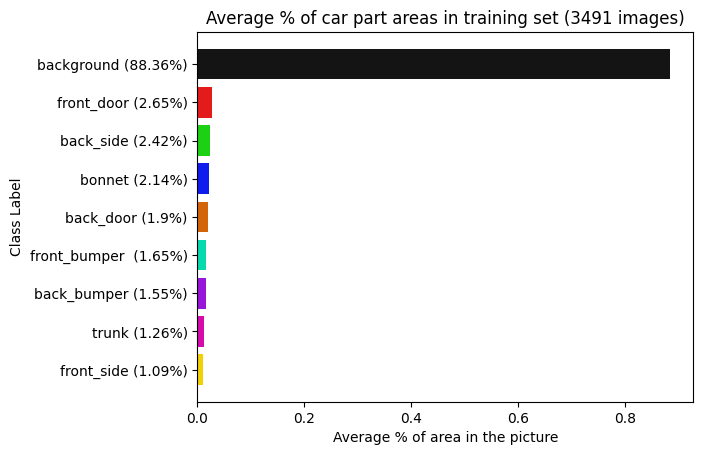

In [11]:
# plot class avg area
plt.barh(list(range(nb_max_classes)), list(class_avg_area.values()), color= [all_colors[aClass] for aClass in list(class_avg_area.keys())])
plt.yticks(list(range(nb_max_classes)), [f'{all_names[c]} ({round(class_avg_area[c]*100, 2)}%)' for c in list(class_avg_area.keys())])
plt.ylabel('Class Label')
plt.xlabel('Average % of area in the picture')
plt.title(f'Average % of car part areas in training set ({len(files_to_consider)} images)')
plt.show()

In [28]:
opel_stems = [a for a in train_stems if 'OPEL' in a]
print(f'Nb of OPEL cars: {len(opel_stems)} ({round(100*len(opel_stems)/len(train_stems), 1)} %)')

doors_stem = [a for a in train_stems if 'DOOR' in a]
print(f'Nb of DOOR cars: {len(doors_stem)} ({round(100*len(doors_stem)/len(train_stems), 1)} %)')

cycleGan_stem = [a for a in train_stems if '_a' in a]
print(f'Nb of CycleGAN cars: {len(cycleGan_stem)} ({round(100*len(cycleGan_stem)/len(train_stems), 1)} %)')

real_stem = [a for a in train_stems if a.isdigit()]
print(f'Nb of real cars: {len(real_stem)} ({round(100*len(real_stem)/len(train_stems), 1)} %)')

assert len(opel_stems)+len(doors_stem)+len(cycleGan_stem)+len(real_stem) == len(train_stems)

Nb of OPEN cars: 1459 (41.8 %)
Nb of DOOR cars: 834 (23.9 %)
Nb of CycleGAN cars: 69 (2.0 %)
Nb of real cars: 1129 (32.3 %)
